In [1]:
import xopt
import yaml

with open("run_results_2024_03_24/BAX_run_be_5.yml") as stream:
    data = yaml.safe_load(stream)

In [2]:
from xopt import VOCS

variables = {
 # 'QUAD:GUNB:212:1:BCTRL': [-0.005, 0.005],
 # 'QUAD:GUNB:212:2:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:823:1:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:823:2:BCTRL': [-0.005, 0.005],
 'QUAD:HTR:120:BCTRL': [-4.48, 1],
 # 'QUAD:HTR:140:BCTRL': [-4.4778, 4.4762],
 # 'QUAD:HTR:300:BCTRL': [-4.46035, 4.4692],
 # 'QUAD:HTR:320:BCTRL': [-4.46919, 4.4792],
 # 'SOLN:GUNB:212:BCTRL': [0.044, 0.044574],
 'SOLN:GUNB:823:BCTRL': [0.021, 0.0255],
}

#construct vocs
vocs = VOCS(
    variables = variables,
    observables = ['xrms_sq', 'yrms_sq'],
)



In [3]:
from xopt.evaluator import Evaluator

def evaluate():
    return 0

evaluator = Evaluator(function=evaluate)

In [5]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from copy import deepcopy
import torch
from test_algorithm import MinimizeEmitBmag

meas_dim = 2
tuning_dims = [0,1,3]

covar_module = (MaternKernel(ard_num_dims=len(tuning_dims),
                              active_dims=tuning_dims,
                              lengthscale_prior=None) *
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )
scaled_covar_module = ScaleKernel(covar_module)

# prepare options for Xopt generator
covar_module_dict = {'xrms_sq': scaled_covar_module, "yrms_sq": deepcopy(scaled_covar_module)}
model_constructor = StandardModelConstructor(
    covar_modules=covar_module_dict, use_low_noise_prior=True
)

QUAD_LENGTH = 0.124 # m
rmat_x = torch.tensor([[-2.3353,    4.9351],
   [-0.4769,   0.5796 ]])
rmat_y = torch.tensor([[3.1537,   5.5806],
[ 0.1835,    0.6419]])
THICK_QUAD = False
BEAM_ENERGY = 0.088 # GeV
SCALE_FACTOR = 2.74 # multiplicative factor to convert from measurement quad PV units to geometric focusing strength

algo_kwargs = {
        'x_key': "xrms_sq",
        'y_key': "yrms_sq",
        'scale_factor': SCALE_FACTOR,
        'q_len': QUAD_LENGTH,
        'rmat_x': rmat_x,
        'rmat_y': rmat_y,
        'n_samples': 20,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 11,
        'thick_quad': THICK_QUAD,
        'init': 'smallest',
        'scipy_options': {'maxiter':25},
        'jitter': 0.1,
        'twiss0_x':torch.tensor([5.012, 0.0487]),
        'twiss0_y':torch.tensor([5.012, 0.0487])
}
algo = MinimizeEmitBmag(**algo_kwargs)

In [6]:
from xopt.generators.bayesian.bax_generator import BaxGenerator
from xopt import Xopt
import pandas as pd


#construct BAX generator
generator = BaxGenerator(
    vocs=vocs,
    gp_constructor=model_constructor,
    algorithm=algo,
    #numerical_optimizer=GridOptimizer(n_grid_points=10),
    n_interpolate_points=5
)
generator.numerical_optimizer.max_time = 10.0
generator.numerical_optimizer.n_restarts = 128

#construct Xopt optimizer and add data
X_bax = Xopt(
    evaluator=evaluator,
    generator=generator,
    vocs=vocs,
)
X_bax.add_data(pd.DataFrame(data['data']))

/usr/local/lcls/package/anaconda/envs/python3.9envs/rhel7/nightly/03-27-2024/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lcls/package/anaconda/envs/python3.9envs/rhel7/nightly/03-27-2024/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


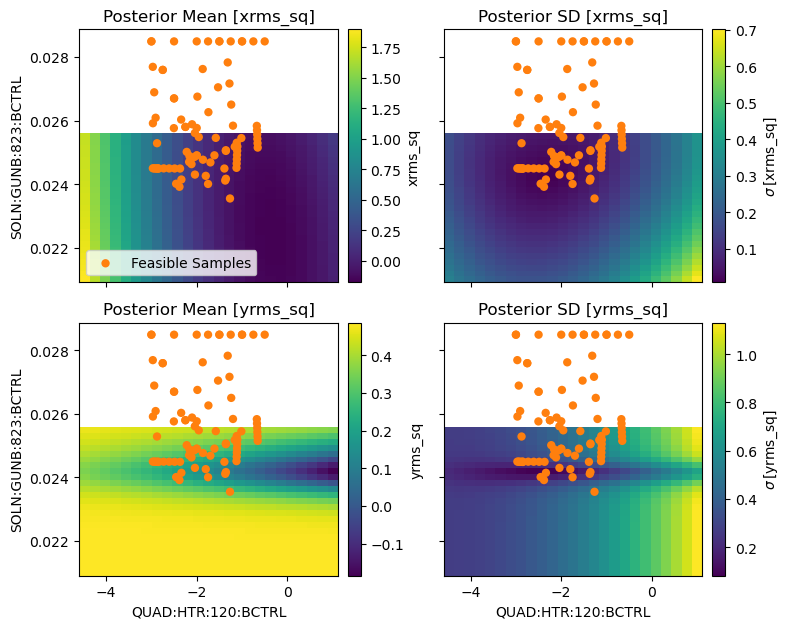

In [7]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X_bax.generator.train_model()
fig,ax = visualize_generator_model(
    X_bax.generator,
    variable_names=['QUAD:HTR:120:BCTRL','SOLN:GUNB:823:BCTRL'],
    output_names=["xrms_sq","yrms_sq"],
    show_acquisition=False,
    n_grid=25
)


/usr/local/lcls/package/anaconda/envs/python3.9envs/rhel7/nightly/03-27-2024/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lcls/package/anaconda/envs/python3.9envs/rhel7/nightly/03-27-2024/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lcls/package/anaconda/envs/python3.9envs/rhel7/nightly/03-27-2024/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


{'QUAD:GUNB:823:1:BCTRL': tensor(0.0028, dtype=torch.float64), 'QUAD:GUNB:823:2:BCTRL': tensor(0.0022, dtype=torch.float64), 'SOLN:GUNB:823:BCTRL': tensor(0.0237, dtype=torch.float64)}


/home/physics/rroussel/SLAC_Xopt/lcls_ii/emittance/bax/test_algorithm.py:658: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_origin += [torch.tensor(reference_point[name]).reshape(1,1)]
/usr/local/lcls/package/anaconda/envs/python3.9envs/rhel7/nightly/03-27-2024/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lcls/package/anaconda/envs/python3.9envs/rhel7/nightly/03-27-2024/lib/python3.9/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lcls/package/anaconda/envs/python3.9envs/rhel7/nightly/03-27-2

(<Figure size 900x600 with 6 Axes>,
 array([[<Axes: xlabel='QUAD:GUNB:823:1:BCTRL', ylabel='Emittance'>,
         <Axes: xlabel='QUAD:GUNB:823:2:BCTRL'>,
         <Axes: xlabel='SOLN:GUNB:823:BCTRL'>],
        [<Axes: xlabel='QUAD:GUNB:823:1:BCTRL', ylabel='Sample Validity Rate'>,
         <Axes: xlabel='QUAD:GUNB:823:2:BCTRL'>,
         <Axes: xlabel='SOLN:GUNB:823:BCTRL'>]], dtype=object))

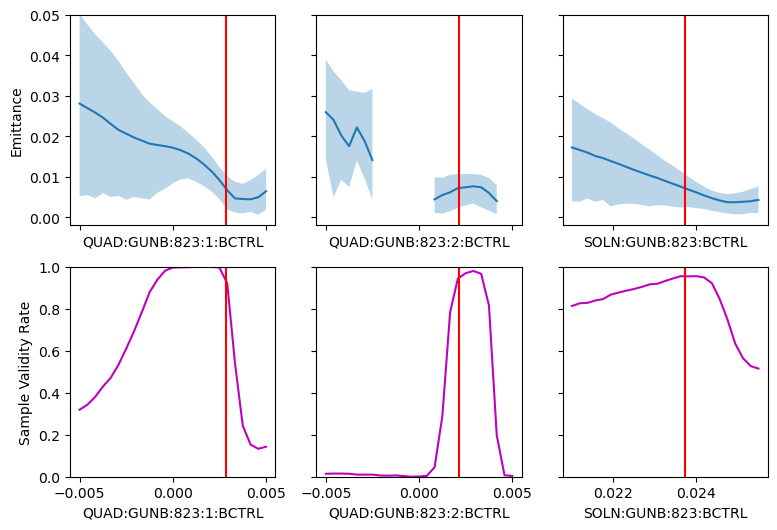

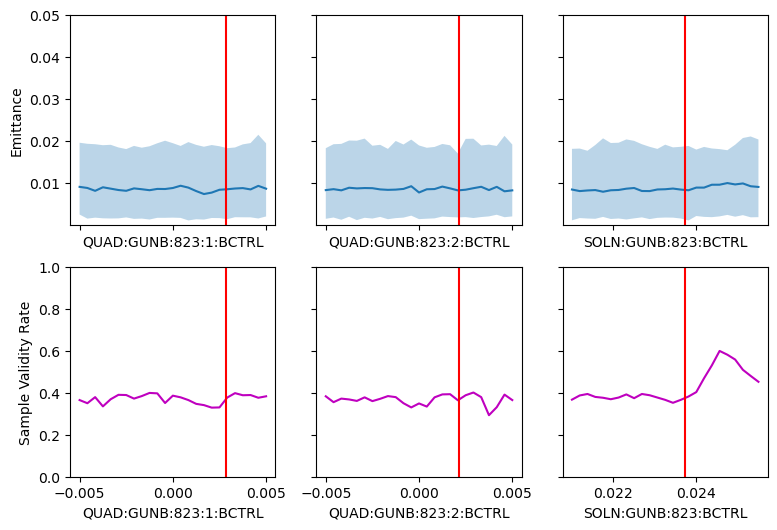

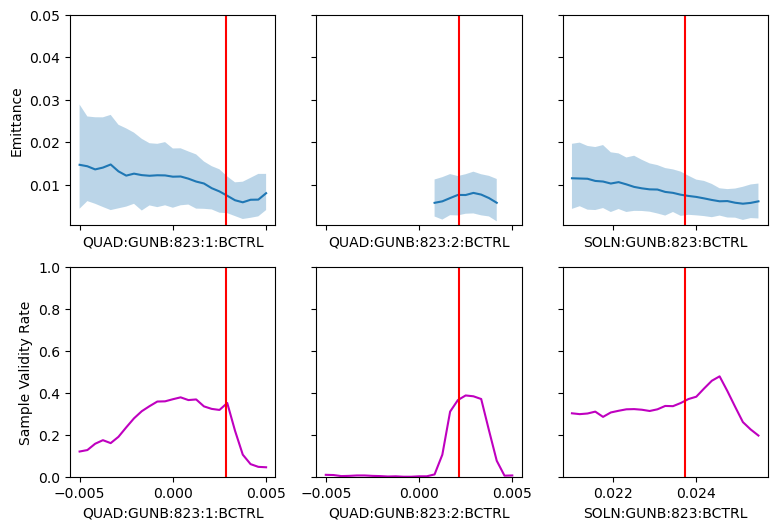

In [8]:
from test_algorithm import plot_virtual_emittance
from emitopt.utils import get_bax_optimum

X_bax.generator.generate(1)
best_x = get_bax_optimum(X_bax.generator)
print(best_x)
plot_virtual_emittance(
    X_bax, best_x, 
    n_points=25, dim="x", y_max=0.05
)
plot_virtual_emittance(
    X_bax, best_x, 
    n_points=25, dim="y", y_max=0.05
)
plot_virtual_emittance(
    X_bax, best_x, 
    n_points=25, y_max=0.05
)